# Week 7 Lecture Code: Word Embeddings / Clustering / tSNE visualization

**March 2024**

This is code that was discussed in the class notes for the two lectures in Week 7.

**Table of Content**

1. [Installing packages](#sec1)
2. [Generating Word Embeddings and heatmaps for cosine similarity](#sec2)
3. [K-means clustering with word embeddings](#sec3)
4. [Using the Elbow method to find the best k for k-means](#sec4)
5. [t-SNE visualization](#sec5)

<a id="sec1"></a>
## 1. Installing Packages

This notebook contains several packages that we are using for the first time. Additionally, we might need to use these packages for the project too, thus, it's good if we install them within the virtual environment of the project.  

However, if we install the packages within Jupyter, they are installed in our system-wide Python installation. We need to take some extra steps to ensure that the new packages are installed for our project-specific virtual environment. Here is what you need to do:

1. Make sure that you have created the virtual environment for Project 2 (about collecting data with PykTok). You can find the instructions under Week 7 Programming Activities.
2. Open a terminal window, navigate to the folder where you created your virtual environment, and then type `source .project2/bin/activate`.
3. Install the following package: `pip install ipykernel`, to manage virtual environments within Jupyter notebooks.
4. Register our virtual environment with Jupyter: `python -m ipykernel install --user --name=.project2 --display-name="CS315 Project2`
5. At this point close this notebook and then restart it again.
6. When you reopen the notebook, find the button "Python 3 (ipykernel)" on the top right corner. Click on it, you should see the following dialog, where you should select our virtual environment that we gave the display name CS315 Project2: ![Screenshot: Kernel selection](https://cs.wellesley.edu/~eni/cs315/choose-kernel.png)
7. Before moving on, run the cell below, just to make sure that you are really running the virtual environment.

In [1]:
import sys
print(sys.executable)

/Users/jas/miniconda3/envs/pyktok2/bin/python


If all the prior steps were successful, you should be able to see something similar to the path below, including `.project2/bin/python`
![Screenshot: Path](https://cs.wellesley.edu/~eni/cs315/path-confirmation.png)

Now you are ready to continue with the following installations for libraries used in this notebook:

In [3]:
pip install tensorflow tensorflow_hub scikit-learn seaborn plotly nbformat

Note: you may need to restart the kernel to use updated packages.


If the installation was successful, you are ready to continue. If you run into issues, let me know.

<a id="sec2"></a>
## 2. Generating word embeddings

We will use the `tensorflow` library that loads the Universal Sentence Encoder from Google. Running the cells below takes several seconds, this is why it's good to have a notebook that you keep open and running to avoid having to repeat these steps everytime.

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

2024-03-29 10:57:33.175332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Load the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Let's see what `embed` is:

In [7]:
type(embed)

tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

It seems like instance of a class that is loading a saved model for the user.

We know that `embed` expects a list of words, thus, even if we want the embedding of one single word, we put it in a list:

In [8]:
# get the word embedding of a single word
embed(["apple"])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-0.04391913,  0.0320113 ,  0.01190968,  0.03629498, -0.00428854,
        -0.04623364,  0.01953795, -0.0766146 , -0.04304637,  0.03870977,
        -0.04847969, -0.05598783, -0.07318962, -0.01257848, -0.08900222,
         0.03608384, -0.03099001, -0.03288192,  0.02245502, -0.0736437 ,
        -0.0434471 ,  0.01525586, -0.01991093, -0.00087343, -0.02389864,
         0.08860015,  0.00602733, -0.04430725,  0.04500024, -0.0135637 ,
        -0.04075949, -0.0187194 , -0.01410533,  0.01902026, -0.07315566,
         0.03898572, -0.05082062,  0.01163179,  0.01045336, -0.01495851,
         0.05237336, -0.02879025, -0.0653019 , -0.02734277,  0.00342714,
         0.0791077 , -0.0050046 ,  0.00479219, -0.00226162, -0.03844388,
        -0.02335557, -0.00376969,  0.08060665,  0.07994739, -0.07976856,
        -0.08015751,  0.05998326,  0.02709489,  0.07591496,  0.01611827,
        -0.03375887, -0.02939119,  0.05382704,  0.0583757 ,  0.02365993,
 

From the result, we can see that we got a tensor of shape 1x512, meaning a single row with 512 columns (the dimensions for the word representation). A tensor is a mathematical term for a multi-dimensional array.

Let's get the embeddings for a few pairs of words that we know are similar:

In [9]:
words = ['king', 'queen', 'radio', 'TV', 'bike', 'car', 'Boston', 'London', 'lake', 'river']

embeddings = embed(words)
embeddings.shape

TensorShape([10, 512])

As we can see, we got one embedding for each word as a vector of 512 dimensions. We will calculate the cosine similarity between these words:

In [10]:
from numpy.linalg import norm

def cosineSimilarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    V1 = np.array(vec1)
    V2 = np.array(vec2)
    cosine = np.dot(V1, V2)/(norm(V1)*norm(V2))
    return cosine

Now that we have this function, we will call it to calculate the similarity between all pairs of words, as part of a new function:

In [11]:
def pairwiseSimilarity(embeddings):
    """Given a matrix of embeddings for words or sentences,
    calculate the cosine similarity for each pair.
    """
    simMatrix = []
    for vec1 in embeddings:
        simRow = []
        for vec2 in embeddings:
            simRow.append(cosineSimilarity(vec1, vec2))
        simMatrix.append(simRow)
    return simMatrix
    
simMatrix = pairwiseSimilarity(embeddings)
print(simMatrix)

[[1.0, 0.58856946, 0.2017837, 0.23791906, 0.2845464, 0.30579725, 0.31222966, 0.3519483, 0.21853511, 0.31288993], [0.58856946, 1.0000001, 0.23228016, 0.21706414, 0.23037918, 0.23948048, 0.23180102, 0.27207547, 0.15932225, 0.22088568], [0.2017837, 0.23228016, 1.0, 0.45328128, 0.28366217, 0.45171037, 0.26606655, 0.34238768, 0.2682847, 0.312001], [0.23791906, 0.21706414, 0.45328128, 1.0, 0.31165937, 0.43531647, 0.24773496, 0.23908722, 0.22314478, 0.33228463], [0.2845464, 0.23037918, 0.28366217, 0.31165937, 1.0, 0.56984055, 0.29134262, 0.33670276, 0.2905055, 0.3785724], [0.30579725, 0.23948048, 0.45171037, 0.43531647, 0.56984055, 1.0, 0.33123642, 0.34563774, 0.27086568, 0.35168734], [0.31222966, 0.23180102, 0.26606655, 0.24773496, 0.29134262, 0.33123642, 1.0000001, 0.49752563, 0.290603, 0.26489943], [0.3519483, 0.27207547, 0.34238768, 0.23908722, 0.33670276, 0.34563774, 0.49752563, 1.0000001, 0.23277909, 0.32204518], [0.21853511, 0.15932225, 0.2682847, 0.22314478, 0.2905055, 0.27086568, 0.2

Let's generate a heatmap to see the similarity between the pairs of words:

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def drawHeatmap(labels, simMtrx, plotTitle):
    """Draws a heatmap for the similarity matrix.
    """
    sns.set(font_scale=0.9)
    g = sns.heatmap(
          simMtrx, # similarity matrix with the cosine sim values
          xticklabels=labels,
          yticklabels=labels,
          vmin=0,
          vmax=1,
          cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=90)
    g.set_title(plotTitle, fontsize=14)
    plt.show()

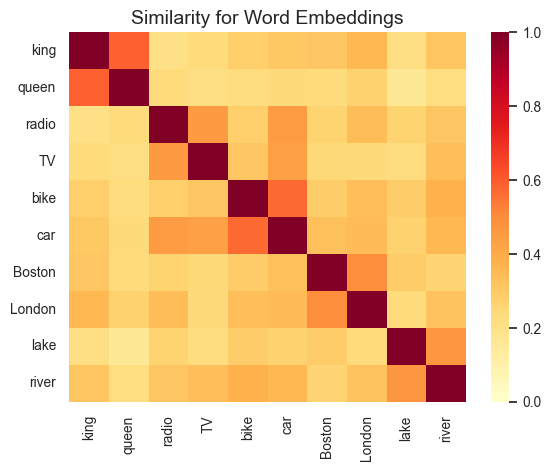

In [14]:
drawHeatmap(words, simMatrix, "Similarity for Word Embeddings")

**Optional Challenge: Find most similar words**

While the heat map gives us some information, is hard to see the most simlar words. We can write a Python function to find the most similar pairs. I wrote one that I can call like this:

`findUniqueTopPairs(simMatrix, words)[:10]`

And the results are the following:
```
[(0.58856946, 'king', 'queen'),
 (0.56984055, 'bike', 'car'),
 (0.49752563, 'Boston', 'London'),
 (0.471712, 'lake', 'river'),
 (0.45328128, 'TV', 'radio'),
 (0.45171037, 'car', 'radio'),
 (0.43531647, 'TV', 'car'),
 (0.3785724, 'bike', 'river'),
 (0.3519483, 'London', 'king'),
 (0.35168734, 'car', 'river')]
```

Notice how our original 5 pairs are at the top, and pairs like 'car' and 'radio' are still related. One can also understand the relationshp between 'London' and 'king' (based on the history of the many kings who lived in London, although for the past 70 years there was a queen in the palace). Anyway, we can see how the similarity is going down.

In [ ]:
# your code

In [16]:
def findUniqueTopPairs(simMatrix, words):
    top_pairs = []
    seen = set()
    for i in range(len(words)):
        for j in range(i+1, len(words)):
            similarity = simMatrix[i][j]
            if (similarity, words[i], words[j]) not in seen:
                top_pairs.append((similarity, words[i], words[j]))
                seen.add((similarity, words[i], words[j]))
    
    top_pairs.sort(reverse=True)
    return top_pairs


words = ['king', 'queen', 'bike', 'car', 'London']

top_pairs = findUniqueTopPairs(similarity_matrix, words)[:10]
print(top_pairs)


[(0.58856946, 'king', 'queen'), (0.56984055, 'queen', 'car'), (0.49752563, 'king', 'car'), (0.3785724, 'queen', 'bike'), (0.3519483, 'king', 'bike'), (0.0, 'queen', 'London'), (0.0, 'king', 'London'), (0.0, 'car', 'London'), (0.0, 'bike', 'car'), (0.0, 'bike', 'London')]


<a id="sec3"></a>
## 3. K-means clustering with word embeddings

In lecture we showed the clustering for the TikTok hashtags collected from posts, but for connecting this section to the t-SNE visualization section below, we will show here the clustering for our own list of news hashtags.

In [ ]:
# get the news hashtags
import json
news = json.load(open('news-hashtags.json'))
news[:10]

**Step 1: Get the word embeddings**

In [ ]:
# remember that we loaded the model in the prior section
newsEmbed = embed(news)
newsEmbed.shape

**Step 2: Perform clustering with a fixed k value**

For this time, we will perform clustering with k=15. The code will take a few seconds (or more) to run:

In [ ]:
from sklearn.cluster import KMeans

k = 15 # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(newsEmbed)

Let's see what the results look like:

In [ ]:
clusters[:10]

They are indices of the clusters. For each elemenent in our `news` list, the `clusters` array indicates in which of the 15 clusters the item has been assigned. We can then use this information to find out which words are in which cluster.

We will print out the composition of each cluster:

In [ ]:
for i in range(k):
    print(f"Cluster {i}:")
    cluster_words = [news[j] for j in range(len(news)) if clusters[j] == i]
    print(cluster_words)

As we discussed when we looked at the t-SNE visualization in class, some groups of words are really meaningful, for example, Cluster 5, Cluster 6, Cluster 8.

<a id="sec4"></a>
## 4. Using the Elbow method to find the best k

We discussed that having to pick k is a limitation of K-means clustering. Below, we show one method known as the Elbow method to try to pick the best k. If you want to learn about the method, here is [a short 4-minute video](https://www.youtube.com/watch?v=ht7geyMAFfA) to explain it. It is called the Elbow method because k is selected at the lowest point that marks something that looks like an elbow. This is the point where the sum of squared distances from the cluster centroid stops decreasing rapidly and enters a phase of a constant-paced decline, toward 0. This sum of squared distances of all points from the cluster centroid is known as inertia. 

In [ ]:
def elbowMethod(embeddings, maxK):
    """
    Implements the Elbow method for finding most optimal k.
    It keeps track of a measure named "inertia" for each cluster.
    """
    sumSquaredDistances = []
    kValues = list(range(1, maxK))
    for k in kValues:
        km = KMeans(n_clusters=k, random_state=42)
        km = km.fit(embeddings)
        sumSquaredDistances.append(km.inertia_)
    
    # plot the line to identify the elbow
    plt.plot(kValues, sumSquaredDistances, 'ro-')
    plt.xlabel('k')
    plt.xticks(kValues)
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

Let's try below 20 values for k:

In [ ]:
elbowMethod(newsEmbed, 20)

In this plot, inertia stops rapidly decreasing at the k=3 and enters a phase of steady decline. So we will pick k=3.

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(newsEmbed)

clusters[:10]

Notices the indices of the clusters: 0, 1, 2. We can check quickly how many items are in each cluster:

In [ ]:
from collections import Counter
Counter(clusters)

So, it looks like the clusters have roughly the same size: 0 and 2 have about 40 items and cluster 1 has 50 items. Let's visualize the clusters using t-SNE.

<a id="sec5"></a>
## 5. t-SNE visualization

To create the t-SNE visualization, we need a few steps to prepare the data first. We work directly with the embeddings and then use the cluster membership as a column that will allow us to color the dots in the scatterplot.

**Step 1: Run the TSNE algorithm**

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)  
tsne_results = tsne.fit_transform(newsEmbed)

**Step 2: Create a dataframe**

In [ ]:
import pandas as pd

df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
df['hashtag'] = news  
df['cluster'] = clusters # the cluster indices where each news hashtags belong
df.head()

**Step 3: Generate Plotly visualization**

In [ ]:
import plotly.express as px

# Create the scatter plot
fig = px.scatter(df, x='tsne_1', y='tsne_2', text='hashtag', color="cluster", color_continuous_scale="BlueRed")

# Format what to show next to the markers
fig.update_traces(textposition='top center', 
                  mode='markers+text', 
                  textfont=dict(size=6))

fig.update_layout(title='Embeddings of TikTok News Hashtags', width=800, height=800)
fig.show()